In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/13 14:46:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/03/13 14:46:43 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/03/13 14:46:43 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
data = spark.read.csv("preprocessed_PCA.csv", header=True, inferSchema=True)
data.show(4)
from pyspark.sql.functions import abs, col
from pyspark.sql import functions as fn

# calculate the minimum value for each column
min_vals = data.agg(*[fn.min(c).alias(c) for c in data.columns])

# get the absolute minimum value from the DataFrame
abs_min = min_vals.select([fn.abs(fn.col(c)).alias(c) for c in min_vals.columns]).first()

included_cols = [c for c in data.columns if c not in ['Amount', 'Class']]
#df_shifted = data.select([col(c) + abs_min[c] for c in included_cols],col('Amount'), col('Class'))
#df_shifted = data.select([col(c) + abs_min[c] for c in included_cols])
df_shifted = data.select(
     *[(col(c) + abs_min[c]).alias(c) if c in included_cols else col(c).alias(c) for c in data.columns]
 )


# shift the data to make all values non-negative
#df_shifted = data.select([col(c) + abs_min[c] for c in data.columns])
df_shifted.show(4)

+----+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------+-----+
|Time|         PC1|         PC2|         PC3|         PC4|         PC5|         PC6|         PC7|         PC8|         PC9|        PC10|        PC11|        PC12|        PC13|        PC14|        PC15|        PC16|        PC17|        PC18|        PC19|        PC20|        PC21|Amount|Class|
+----+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------+-----+
|   0|-1.093789312| 1.777731318|-0.812147507| 1.386259013| 0.093503784|-0.218078736| 1.355688242| 0.864874322| 0.32781929

In [3]:
# Prepare data for training
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=["PC1", "PC2","PC3","PC4", "PC5","PC6","PC7", "PC8","PC9","PC11", "PC11","PC12","PC13","PC14", "PC15","PC16","PC17", "PC18","PC19","PC20","PC21","Amount"], outputCol="features")
data_1 = assembler.transform(df_shifted).select("Class", "features")


In [4]:
data_1.show(2,False)
data2=data_1.withColumnRenamed("Class","label")
data2.show(2,False)

23/03/13 14:46:51 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Class|features                                                                                                                                                                                                                                                                                                           |
+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [5]:
(trainingData, testData) = data2.randomSplit([0.7, 0.3])


In [6]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import NaiveBayes

# Create a VectorAssembler to combine the features into a single vector column

# Use the assembler to transform the training data
#trainingData = assembler.transform(trainingData)

# Use a StandardScaler to standardize the features to have zero mean and unit variance
#scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
#scalerModel = scaler.fit(trainingData)
#trainingData = scalerModel.transform(trainingData)

# Train a Naive Bayes model on the transformed data
nb = NaiveBayes(labelCol="label", featuresCol="features")


import pprint
import time
import datetime

pp = pprint.PrettyPrinter(indent=4)
# start time
start_time = time.time()
datetime_obj1 = datetime.datetime.fromtimestamp(start_time)
print(f"Start time: {datetime_obj1}")


model_nb = nb.fit(trainingData)

# end time
end_time = time.time()
datetime_obj2 = datetime.datetime.fromtimestamp(end_time)

# calculate the difference between start and end times in seconds
duration = end_time - start_time

# display the results
print(f"End time: {datetime_obj2}")
print(f"Duration: {duration} seconds")



Start time: 2023-03-13 14:46:51.679690


End time: 2023-03-13 14:46:53.416547
Duration: 1.7368566989898682 seconds


In [7]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Make predictions on the test data
predictions_nb = model_nb.transform(testData)

# Evaluate the accuracy of the model using the MulticlassClassificationEvaluator
evaluator_nb = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_nb = evaluator_nb.evaluate(predictions_nb)

# Print the accuracy of the model
print("Accuracy NaiveBayes:", accuracy_nb)

23/03/13 14:46:53 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/03/13 14:46:53 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


Accuracy NaiveBayes: 0.8325496110963239


In [8]:
# Create a confusion matrix
from pyspark.sql.functions import col

confusion_matrix_nb = predictions_nb.groupBy("label", "prediction") \
    .count() \
    .orderBy(["label", "prediction"]) \
    .select("label", "prediction", col("count").alias("frequency"))

# Display the confusion matrix
confusion_matrix_nb.show()

+-----+----------+---------+
|label|prediction|frequency|
+-----+----------+---------+
|    0|       0.0|    21185|
|    0|       1.0|     2435|
|    1|       0.0|     3227|
|    1|       1.0|     6966|
+-----+----------+---------+



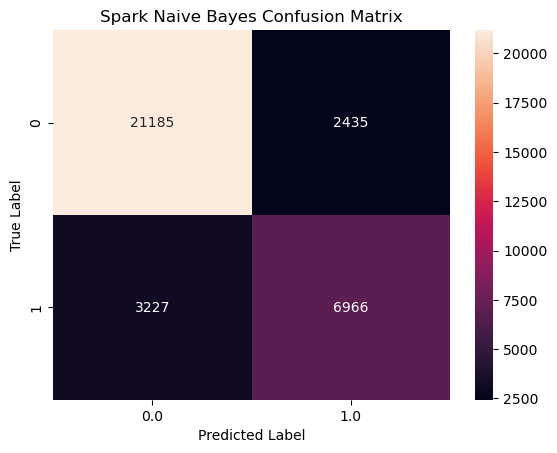

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
# Convert the confusion matrix to a Pandas DataFrame
pandas_df = confusion_matrix_nb.toPandas()

# Create a pivot table to reshape the data for plotting
pivot = pandas_df.pivot(index="label", columns="prediction", values="frequency")

# Create a heatmap plot of the confusion matrix
sns.heatmap(pivot, annot=True, fmt="d")

# Set the plot title and axis labels
plt.title("Spark Naive Bayes Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()